# Прогнозирование оттока клиентов компании «Ниединогоразрыва.ком»

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План проекта

Решение поставленой задачи делится на подзадачи, описанные ниже в плане проекта. Предполагаются следующие этапы решения задачи:

1. Знакомство с данными.
2. Исследовательский анализ данных.
3. Предобработка данных.
4. Выделение целевого признака и feature engineering(если потребуется).
5. Подготовка данных для моделей
6. Разделение данных на обучающую и тестовую выборки.
7. Выбор моделей и их обучение.
8. Контроль метрики ROC AUC.

При достижении необходимого значения контролируемой метрики получаем одну или несеолько моделей для дальнейшей рекомендации в продакшн. При недостижении метрики повторяем пункты 7 и 8 до получения нужного результата. Если более "шустрые" и легкие модели не смогут осилить задачу, есть смысл рассмотреть ансамбль моделей или нейросеть. В противном случае высоконагруженая модель нецелесообразна.

## Знакомство с данными и исследовательский анализ данных

### Знакомство с данными

Прежде всего, импортируем необходимые инструменты для дальнейшей работы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

Напомним, что данные хранятся в нескольких датасетах, более подробная информация о них указана в разделе "1.2. Описание данных".

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.sample(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1891,4193-ORFCL,2019-10-01,2019-11-01 00:00:00,Month-to-month,No,Mailed check,45.10,45.1
496,4134-BSXLX,2017-10-01,No,Month-to-month,No,Mailed check,60.90,1785.65
757,0030-FNXPP,2019-11-01,No,Month-to-month,No,Mailed check,19.85,57.2
3311,6137-MFAJN,2016-02-01,No,Month-to-month,Yes,Electronic check,44.80,2104.55
4484,7465-ZZRVX,2020-01-01,No,Month-to-month,Yes,Electronic check,70.35,70.35
5979,2675-IJRGJ,2015-09-01,No,Two year,No,Bank transfer (automatic),19.65,978
3724,5201-CBWYG,2014-12-01,No,One year,No,Bank transfer (automatic),24.80,1476.25
4291,2789-CZANW,2014-10-01,No,Two year,No,Bank transfer (automatic),110.30,6997.3
3178,2834-SPCJV,2015-08-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,84.10,4348.65
1091,5832-TRLPB,2017-09-01,No,One year,Yes,Bank transfer (automatic),75.35,2243.9


In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.sample(15)

,customerID,gender,SeniorCitizen,Partner,Dependents
1012,7426-RHZGU,Male,0,No,No
6441,5084-OOVCJ,Female,0,Yes,Yes
5469,6538-POCHL,Male,0,No,No
1152,4320-QMLLA,Male,0,No,No
5325,2690-DVRVK,Male,0,Yes,Yes
2064,7061-OVMIM,Female,0,Yes,Yes
460,4719-UMSIY,Male,0,No,Yes
1348,1184-PJVDB,Male,0,Yes,No
2545,0654-PQKDW,Female,0,Yes,Yes
6062,3055-OYMSE,Female,1,No,No


In [5]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.sample(15)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
600,8405-IGQFX,Fiber optic,No,No,Yes,Yes,Yes,No
1582,7639-OPLNG,DSL,Yes,Yes,Yes,Yes,Yes,No
2515,6817-WTYHE,DSL,No,No,No,No,No,No
2261,5696-QURRL,DSL,No,No,No,No,No,No
3034,2223-GDSHL,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
2405,5762-TJXGK,DSL,Yes,Yes,Yes,No,Yes,Yes
396,3552-CTCYF,Fiber optic,No,Yes,Yes,No,Yes,Yes
2950,3537-HPKQT,Fiber optic,No,Yes,No,No,No,No
5437,6394-MFYNG,Fiber optic,No,Yes,Yes,No,Yes,Yes
1892,4083-BFNYK,Fiber optic,Yes,Yes,No,No,No,Yes


In [7]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.sample(15)

,customerID,MultipleLines
1931,7707-PYBBH,No
3356,7032-LMBHI,Yes
654,5244-IRFIH,Yes
4431,1193-RTSLK,No
1736,3143-ILDAL,Yes
4655,5980-NOPLP,Yes
5384,8398-TBIYD,Yes
4389,3339-EAQNV,Yes
4383,6654-QGBZZ,No
442,4134-BSXLX,No


In [9]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Видно, что полученные данные не имеют пропусков, однако хранятся не всегда в верных форматах. Более того, длины датасетов разные, что говорит нам о том, что не все клиенты пользуются всеми услугами. Приступим к исследовательскому анализу.

### Исследовательский анализ и предобработка данных

Для удобства дальнейшей роботы объеденим все датасеты в один общий

In [10]:
df=df_contract.merge(df_personal, on='customerID', how='outer').merge(
    df_internet, on='customerID', how='outer').merge(df_phone,on='customerID', how='outer')
df.sample(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1729,8226-BXGES,2014-10-01,No,One year,No,Bank transfer (automatic),89.45,5692.65,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,No,No,No,Yes
3632,2203-GHNWN,2018-02-01,No,Month-to-month,Yes,Mailed check,79.65,1928.7,Female,0,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3718,8468-EHYJA,2015-05-01,No,Month-to-month,Yes,Electronic check,99.65,5497.05,Female,0,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes
6897,2363-BJLSL,2014-12-01,No,Month-to-month,Yes,Bank transfer (automatic),80.40,4981.15,Male,0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,No
6305,1597-LHYNC,2017-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,95.00,2497.2,Female,1,No,No,Fiber optic,Yes,Yes,No,No,No,Yes,Yes
5634,2320-JRSDE,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,19.90,19.9,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6144,2322-VCZHZ,2018-03-01,No,Month-to-month,Yes,Electronic check,90.00,2024.1,Male,1,Yes,No,Fiber optic,Yes,Yes,No,No,No,Yes,No
5196,0786-IVLAW,2014-08-01,No,One year,No,Bank transfer (automatic),108.10,7238.6,Female,1,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
2341,4304-TSPVK,2014-06-01,No,Two year,No,Bank transfer (automatic),114.90,7843.55,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6418,2486-WYVVE,2017-07-01,No,One year,Yes,Mailed check,79.30,2484,Male,0,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Yes


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


Появившиеся пропуски объясняются тем, что не все клиенты используют полный пакет услуг оператора связи.

Начнём предобработку данных. В первую очередь, выделим целевой призхнак, а именно, является ли в данный момент клиент абонентом оператора "Ниединогоразрыва.ком". Для этого обратимся к столбцу *EndDate*. Если он содержит дату, значит клиент уже ушёл, если нет - клиент всё пользуется услугами оператора.

In [12]:
df['StillClient'] = df['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')

Сразу можно обратить внимание, что даты содержатся в неверном формате, что необходимо исправить. Имеющиеся у нас данные актуальны на первое февраля 2020 года, значит, если клиент всё еще использует услуги, то вместо условного пропуска в графе *EndDate* укажем эту дату.

In [13]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d') 

In [14]:
df['EndDate'] = df['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [15]:
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

Сразу можно заметить, что сами по себе эти две колонки не имеют какого-то интереса для нас, но из них можно извлечь более показательный признак - срок пользования тарифом.

In [16]:
df['DaysInUse'] = (df['EndDate']-df['BeginDate']).astype('timedelta64[D]').astype('int64')

Общие затраты хранятся в строковом формате, хотя это, очевидно, численный признак.

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Столбец *SeniorCitizen*(пенсионер) записан в числовом формате, хотя это категориальный признак

In [18]:
df['SeniorCitizen']=df['SeniorCitizen'].apply(lambda x: 'No' if x ==0 else 'Yes')

На всякий случай проверим наличие дубликатов

In [19]:
df.duplicated().value_counts()

False    7043
dtype: int64

Взглянем на общую информацию по вновь полученному датафрейму

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
StillClient         7043 non-null object
DaysInUse     

В графе *TotalCharges* появились пропуски после приведения её значений к числовому типу. Необходимо выяснить, в чем дело

In [21]:
df['TotalCharges'].isna().sum()

11

In [22]:
df.sort_values('TotalCharges').tail(11)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,StillClient,DaysInUse
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,No,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,No,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,No,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,No,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,No,0


Все пропуски связаны с тем, что данные абоненты подключились в день формирования базы. Логично заполнить пропущенные значения значениями из графы *MounthlyCharges*, потому что абоненты при подключении должны оплатить как минимум первый месяц пользования услугами.

In [23]:
df['TotalCharges'] = np.where(df['TotalCharges'] > 0, df['TotalCharges'], df['MonthlyCharges'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
StillClient         7043 non-null object
DaysInUse     

Более пропусков, не связанных с объединением таблиц, нет. Взглянем на то, как распределены данные. Для этого, напишем функции для построения графиков для категориальных и числовых признаков.

In [25]:
def categorial_feature_distribution(df, column):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.xticks(rotation=0)
    sns.countplot(x=column, data=df, palette='coolwarm')
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Количество')
    plt.show()

In [26]:
def numerical_feature_distribution(df, column):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.xticks(rotation=0)
    sns.distplot(df[column])
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Плотность частоты')
    plt.show()

Теперь выделим признаки по группам

In [27]:
cat_feat = list(pd.DataFrame(np.where(df.dtypes == object, df.columns, np.NaN))[0].dropna().drop(0, axis = 0))

In [28]:
num_feat = list({'MonthlyCharges', 'TotalCharges', 'DaysInUse'})

Взглянем на распределение категориальных признаков

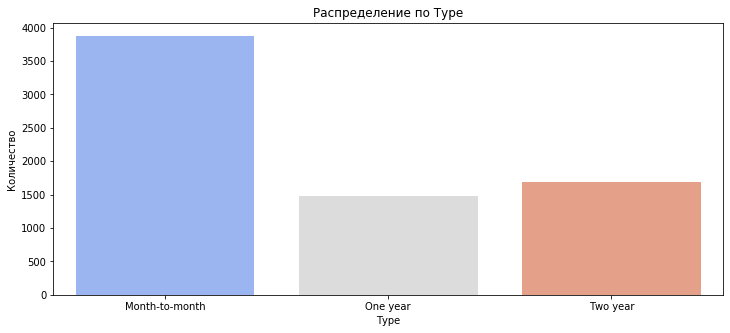

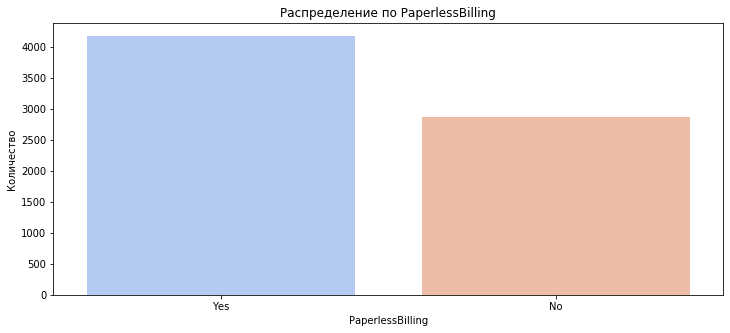

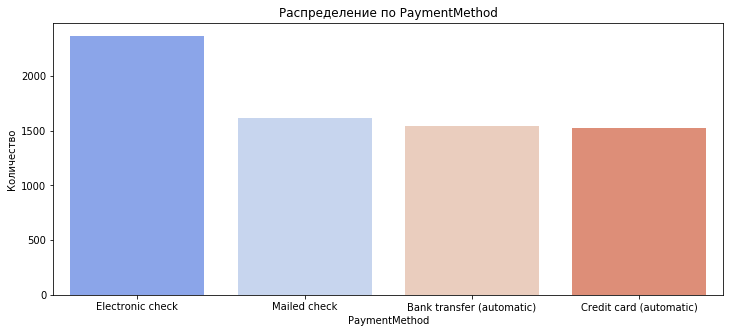

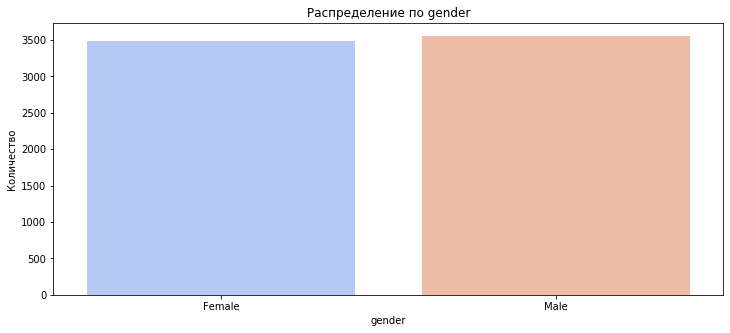

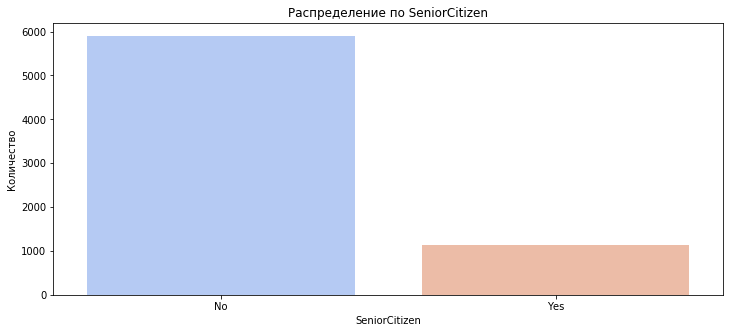

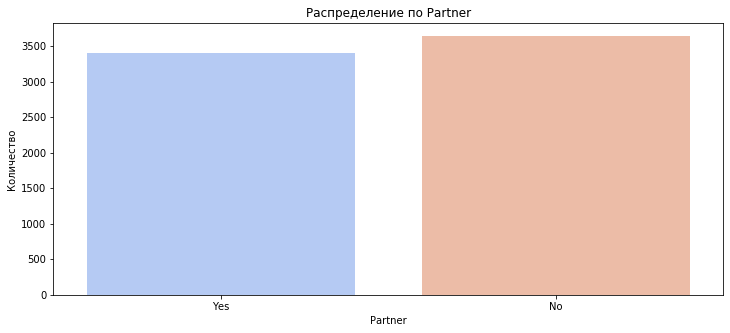

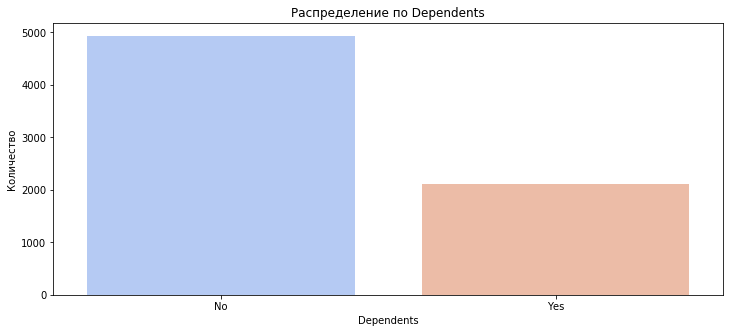

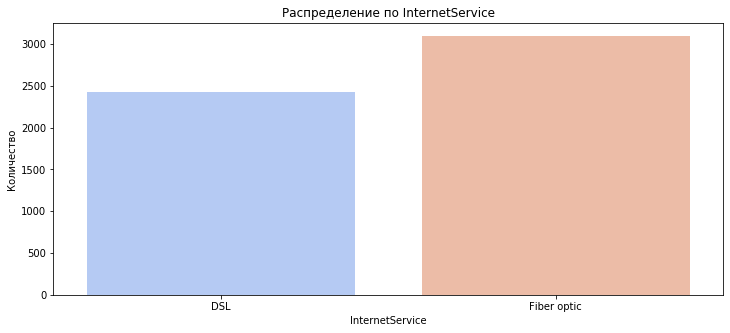

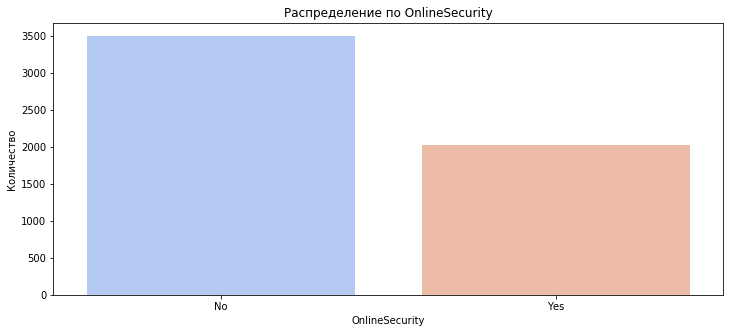

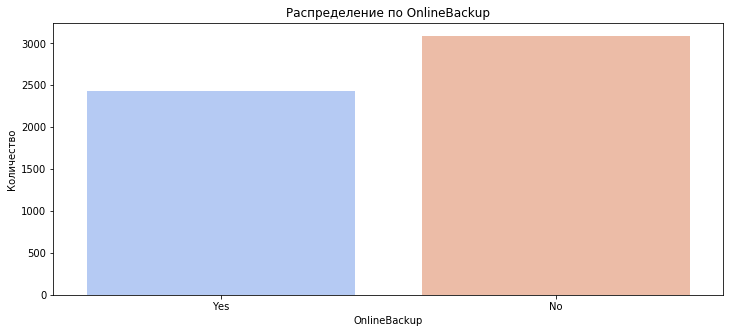

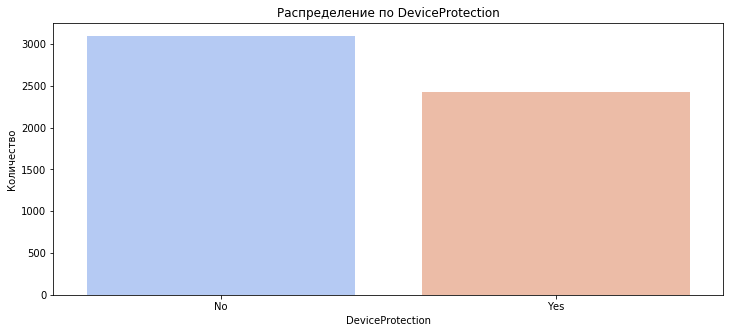

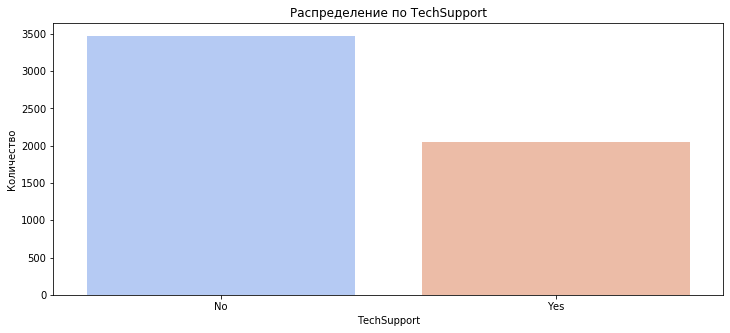

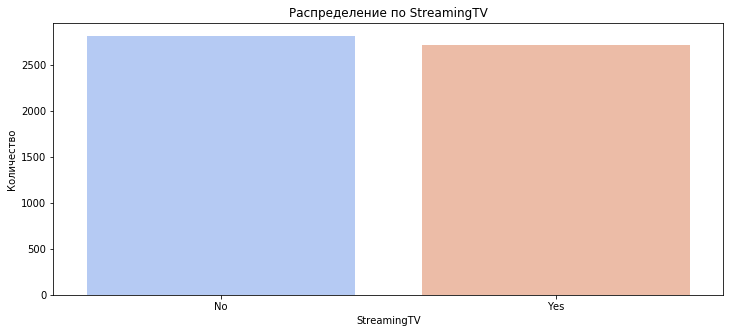

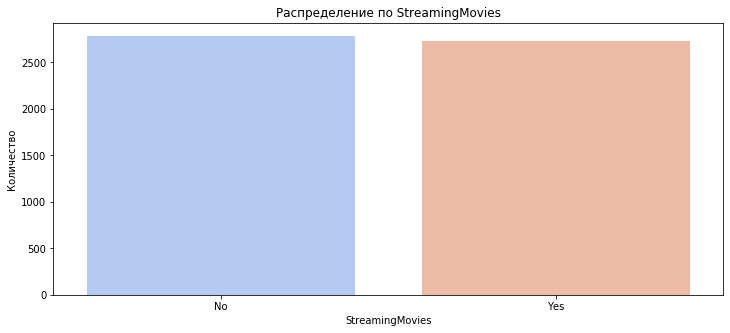

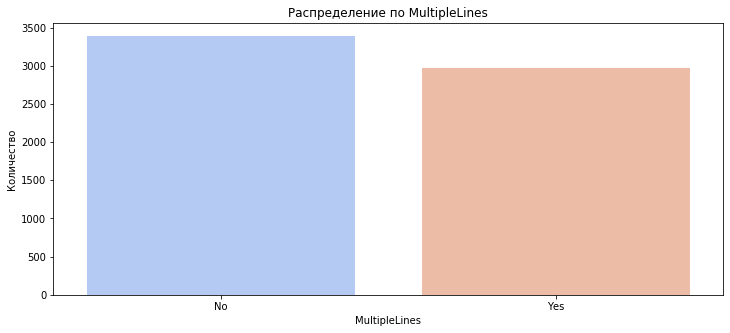

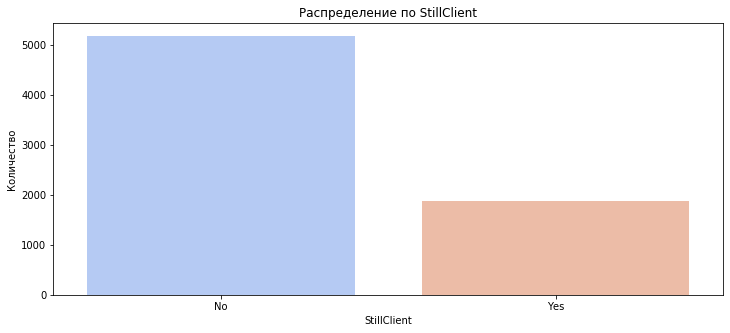

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [29]:
[categorial_feature_distribution(df, item) for item in cat_feat]

По наблюдаемым графикам можно сделать следующие краткие выводы:
- Основной метод оплаты - *Month-to-month* используют примерно 50% пользователей, два других *One yea* и *Two year* используют примерно по 25% пользователей
- Использование безбумажной оплаты более популярно
- *Electronic check* больше всего используется, *Mailed check*, *Credit card (automatic)*, *Bank transfer (automatic)* примерно одинаково
- Отток клиентов по сравнению с лояльными достаточно высок(больше 1/3)
- Распределение по полу практически уравновешено
- Услугами оператора пенсионеры пользуются меньше, чем молодеж
- Наличие партнёра почти не сказывается на пользовании услуг оператора
- Клиентов, не имеющих детей, больше почти в 2 раза
- Большая часть пользователей услуги "Интернет" предпочитает оптоволоконное соединение, однако пользующихся DSL всего на 15% меньше
- Пользователи мало обеспокоены своей безопасностью в интернете, судя по распределению данных OnlineSecurity
- В облачном хранении заинтересовано чуть менее половины пользователей
- Почти в два раза больше пользователей предпочитает не пользоваться предлагаемым антивирусом
- Чаще клиенты предпочитают решать возникшие проблемы самостоятельно, поэтому не тратят деньги на выделенную линию техподдержки
- Примерно поровну распределились пользователи, желающие использовать услуги онлайн ТВ и онлайн кинотеатров
- Предпочитающих телефонную мультилинию немногим меньше, чем клиентов с одной линией.
- Наблюдается перевес в пользу лояльных клиентов, однако порядка 30% пользователей предпочти сменить оператора в течение исследуемого срока

Посмотрим, как распределены численные признаки

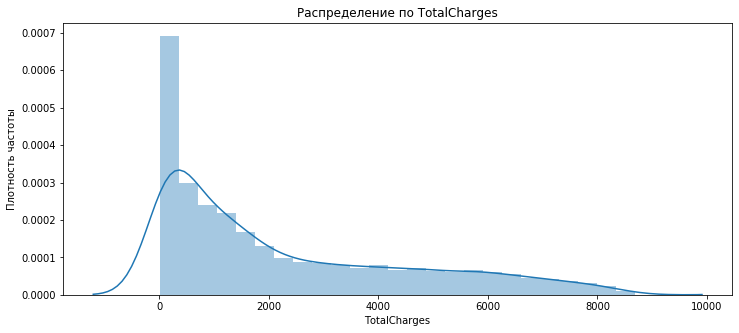

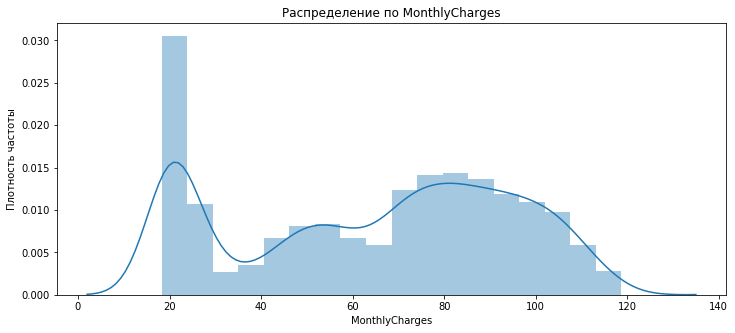

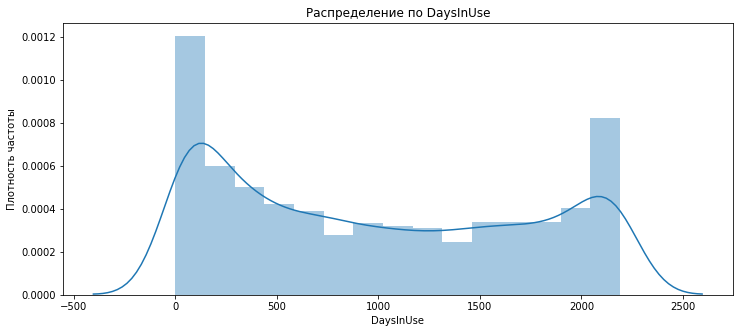

[None, None, None]

In [30]:
[numerical_feature_distribution(df, item) for item in num_feat]

Для полноты картины взглянем на boxplot'ы численных признаков и выведем числовое описание графиков

In [31]:
def boxplot_distribution(df, column):
    sns.color_palette("mako")
    plt.figure(figsize=(15,3))
    sns.boxplot(df[column]).set(xlabel='Значения', ylabel=column)                          
    plt.title(label='"Ящик с усами" по ' + column, fontdict={'fontsize': 18})
    plt.show()
    print('\033[1m'+'Числовое описание графика '+column+'\033[0m')
    print(df[column].describe())

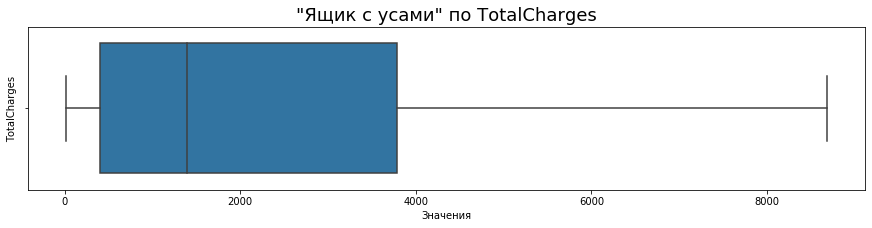

Числовое описание графика TotalCharges
count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


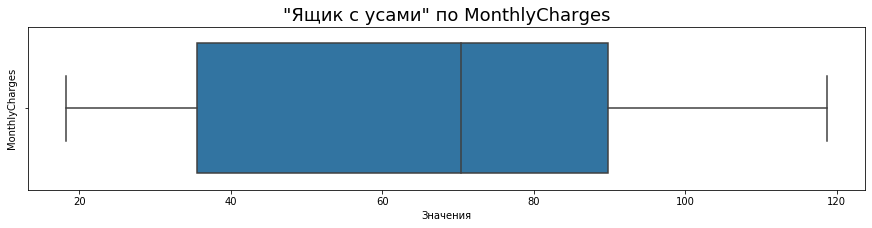

Числовое описание графика MonthlyCharges
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


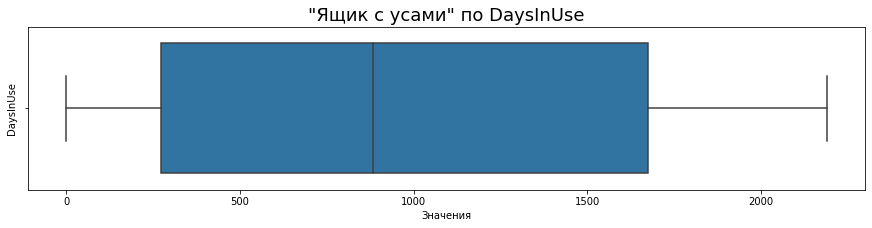

Числовое описание графика DaysInUse
count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: DaysInUse, dtype: float64


[None, None, None]

In [32]:
[boxplot_distribution(df, item) for item in num_feat]

На полученных графиках мы наблдаем:
- *MonthlyCharges* - распределен бимодально, всплески около 20 и 80
- *TotalCharges* - нормальное распределение с положительным смещением
- *DaysInUse* - распределен бимодально, два всплеска - кто пользовался меньше полугода, тех кто больше 3 лет
- бимодальность также означает, что у нас как минмиум две выборки в одной. А значит есть фактор, который этому способствует.

Оценим корреляцию между числовыми признаками

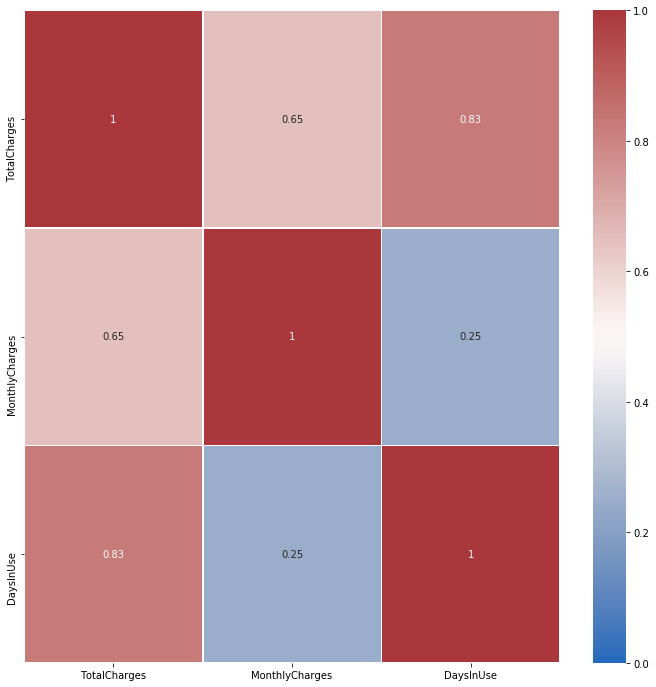

In [33]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df[num_feat].corr(), cmap='vlag', vmin=0, vmax=1,  annot=True, linewidths=.5)
plt.show()

Самая сильная свзяь между общими затратами клиента на связь и сроком пользования услугами оператора, что логично. Менее выражена связь между общими и месячными затратами. Самая слабая связь наблюдается между Сроком пользования и месячным чеком.

Оценим теперь котегориальные признаки в констексте лояльности клиента

In [34]:
def categorial_countplot(df, column):
    fig,ax = plt.subplots(figsize=(12, 5))
    sns.countplot(df[column], hue='StillClient', data=df, palette='coolwarm')
    ax.set_title('Распределение по ' + column)
    ax.set_ylabel('Количество')
    plt.show()

Чтобы не искать несуществующих связей, удалим из списка категориальных признаков *StillClient*

In [35]:
cat_feat.remove('StillClient')

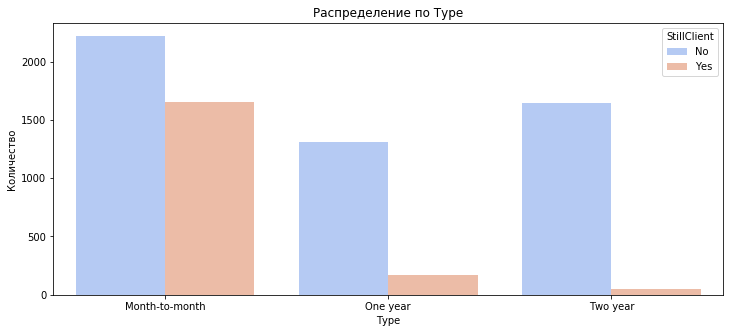

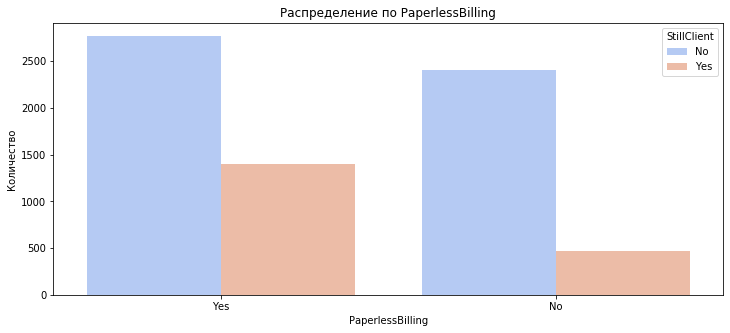

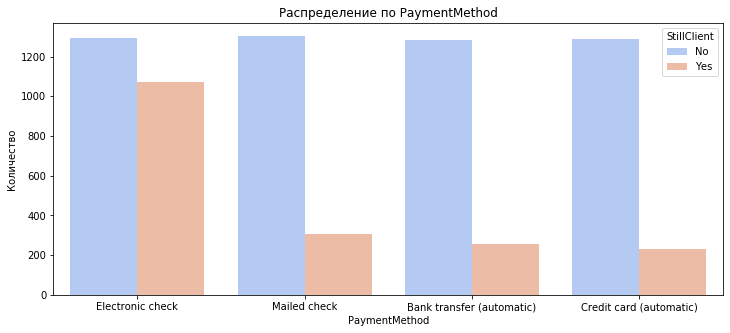

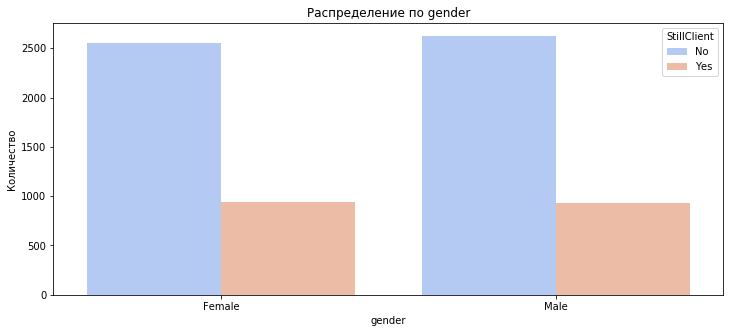

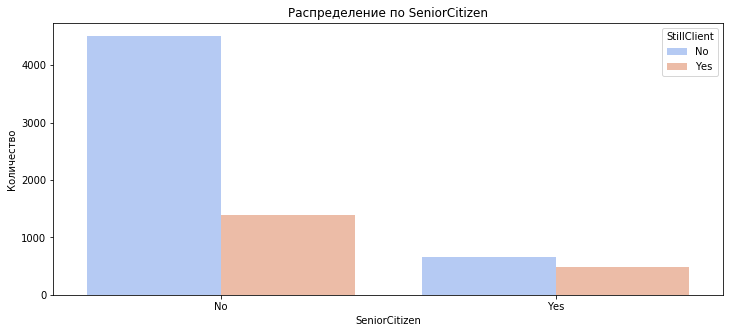

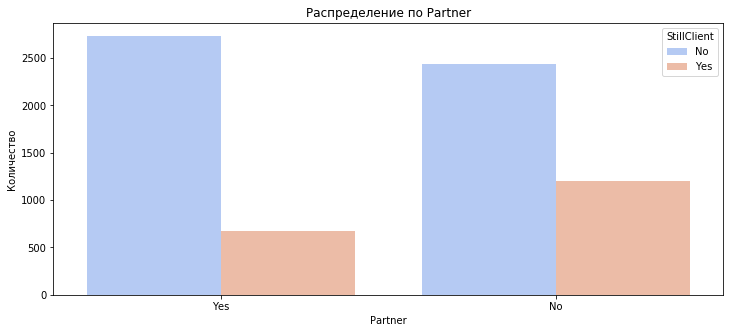

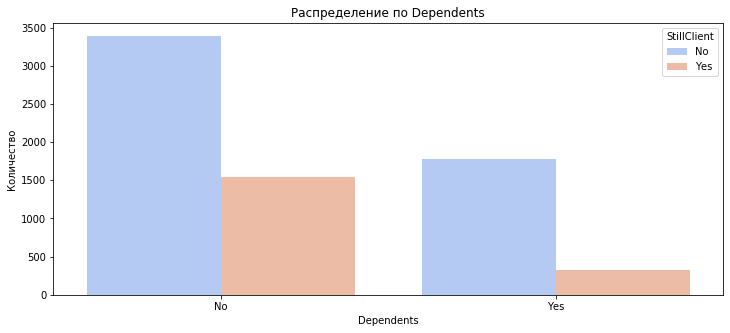

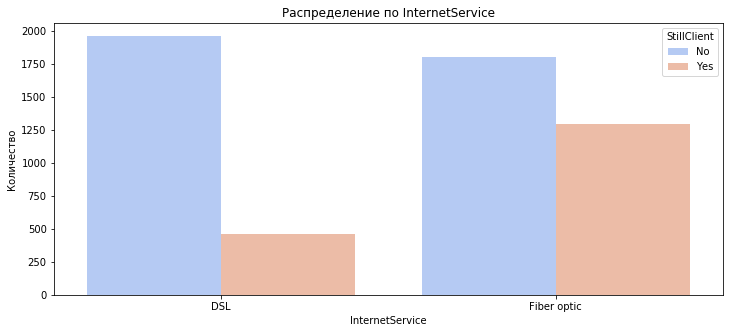

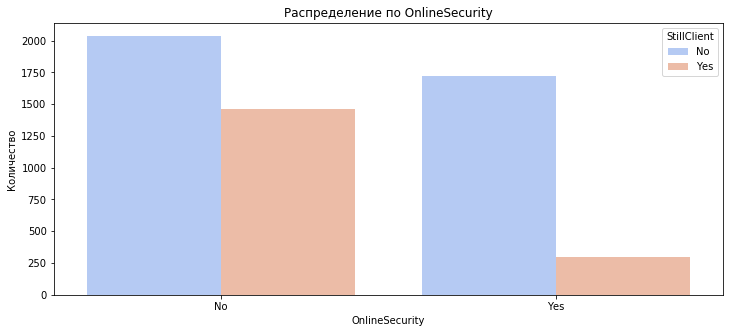

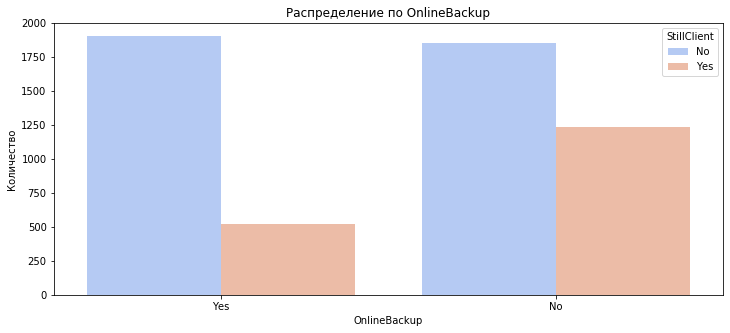

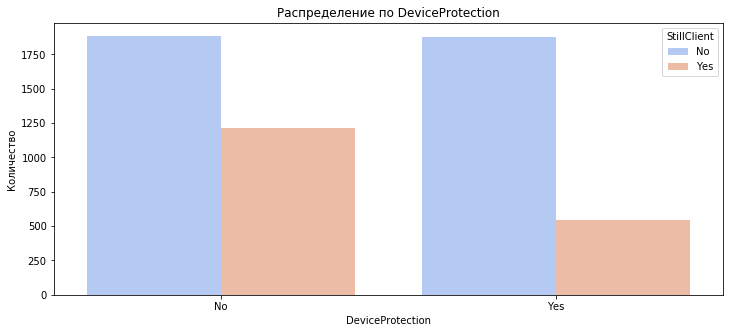

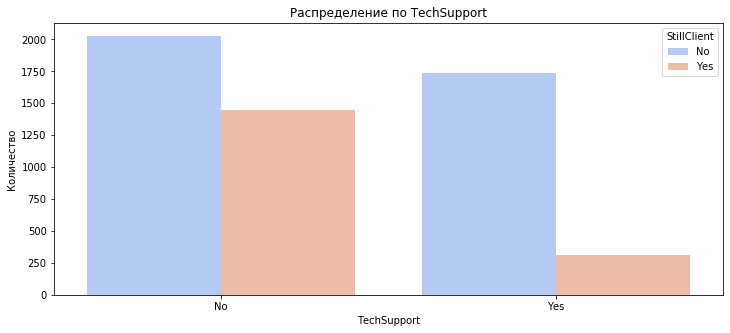

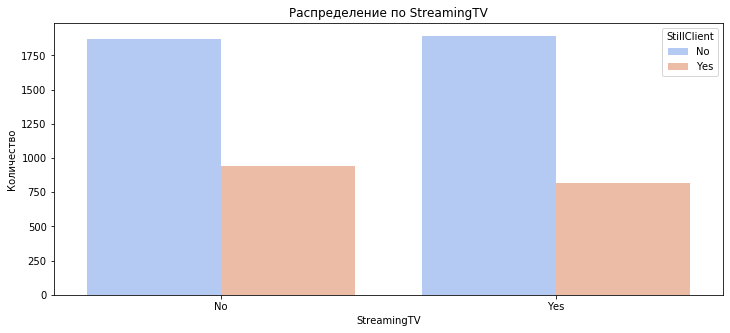

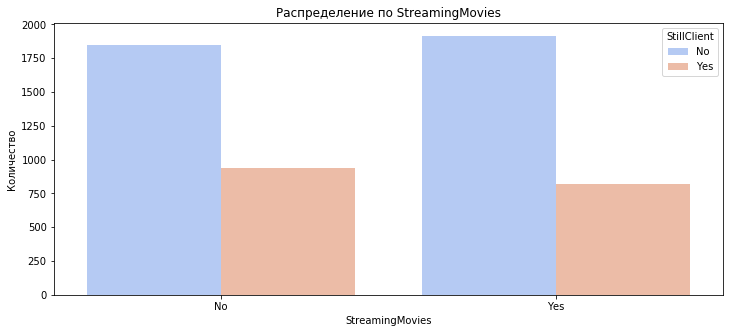

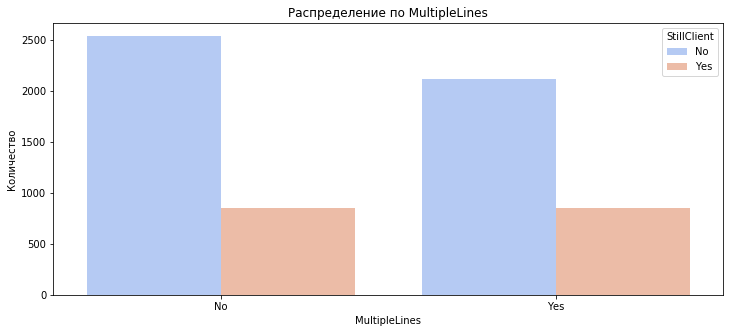

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [36]:
[categorial_countplot(df, item) for item in cat_feat]

По наблюдаемым графикам можно сделать следующие краткие выводы:
- Оплачивающие услуги на длительный срок абоненты (от года и более) чаще более лояльны
- Оплачивающие без бумажных чеков клиенты более склонны к уходу
- У тех, кто оплачивает электронным чеком самый высокий отток, почти равный лояльным, что говорит о возможных проблемах данного метода
- Пол не влияет на лояльность клиента
- Пенсионеры гораздо чаще уходят
- Одиночки чаще отказываются от услуг компании
- Клиенты с детьми реже отказываются от услуг оператора
- Пользователи DSL более консервативны и реже склонны к уходу
- Пользователи блокировки небезопасных сайтов, резервного копирования данных, антивируса и выделенной линии технической поддержки менее склонны к уходу
- Наличие стримингового телевидения и онлайн кинотеатра почти не сказывается на решении клиента об уходе
- Нет связи между количеством телефонных линий у абонента и его потенциальным уходом


Оценим таким же образом численные признаки

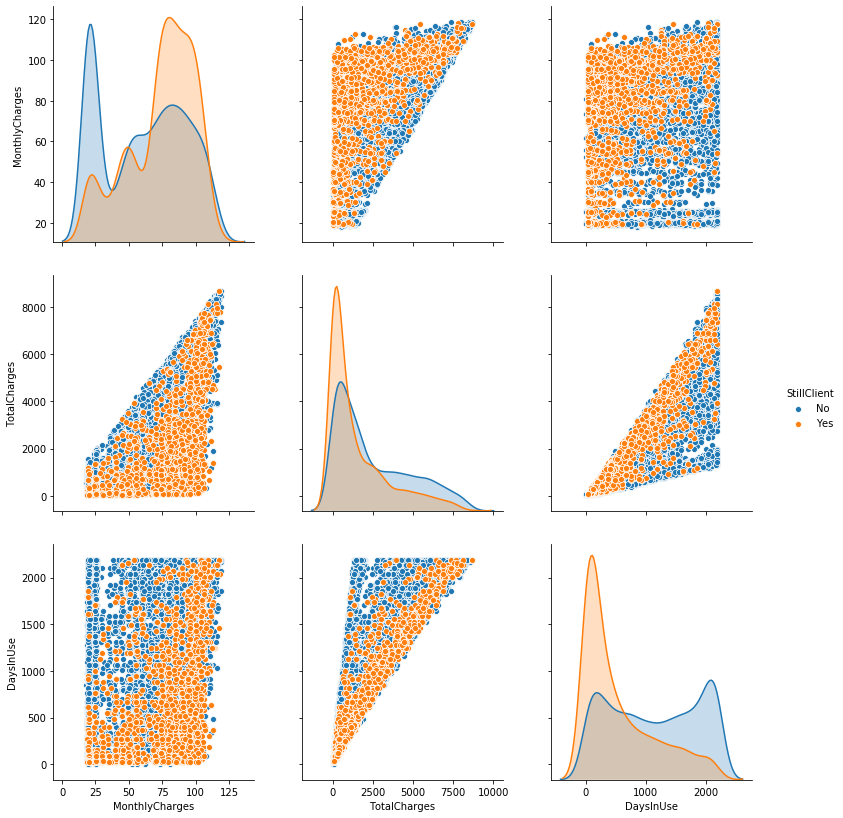

In [37]:
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'DaysInUse','StillClient']], hue='StillClient') \
    .fig.set_size_inches(12,12)

- Уходят в основном те, кто больше платит по ежемесячному счёту
- Общие затраты меншье влияют на лояльность клиента
- Часто клиенты уходят почти сразу после подключения, либо спустя существенное время после начала пользования услугами

По проанализированным данным можно дать некоторые рекомендации, на что стоит обратить внимание оператору воизбежание оттока клиентов, например, сохранить уровень обслуживания интернет сервисов, так как клдиенты, покупающие эти услуги, реже уходят, или обратить внимание на системы электронного расчета, так как чаще пользователи этой услуги предпочитают сменить оператора. 

## Подготовка данных для обучения моделей

Начнём подготовку данных к работе с моделями

Сначала введём дополнительные признаки: выделим пользователей с высоким и низким уровнем риска ухода, а также "премиальных" пользователей, которые пользуются большим количеством услуг

In [38]:
df['HighRisk'] = np.where(df['Type'] is not 'Month-to-month' and df['MonthlyCharges']<df['MonthlyCharges'] \
                          .quantile(.15), 1, 0)

In [39]:
df['PremiumClients'] = np.where([df['DaysInUse'] > 365] and df['MonthlyCharges']>=df['MonthlyCharges'] \
                                .quantile(.75) , 1 ,0)

Преобразуем признак оттока клиентов в численный тип

In [40]:
df['StillClient'] = df['StillClient'].apply(lambda x: 1 if x == 'Yes' else 0)

Удалим ненужные столбцы из заднных

In [41]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

Преобразуем категориальные признаки к численному типу

In [42]:
df = pd.get_dummies(df, drop_first=True)
df

,MonthlyCharges,TotalCharges,StillClient,DaysInUse,HighRisk,PremiumClients,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,31,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,1036,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,1,61,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,1371,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,1,61,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,0,730,0,0,1,0,1,0,...,1,1,0,1,0,1,1,1,1,1
7039,103.20,7362.90,0,2191,0,1,1,0,1,1,...,1,1,1,0,1,1,0,1,1,1
7040,29.60,346.45,0,337,0,0,0,0,1,0,...,1,1,0,1,0,0,0,0,0,0
7041,74.40,306.60,1,123,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1


Поделим данные на тестовую и тренировочную выборки

In [43]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

In [44]:
df_train.shape, df_test.shape

((5282, 24), (1761, 24))

Обозначим наши фичи и признаки

In [45]:
X_train = df_train.drop(['StillClient'], axis=1)
y_train = df_train['StillClient']
X_test = df_test.drop(['StillClient'], axis=1)
y_test = df_test['StillClient']

Преобразуем наши численные признаки

In [46]:
scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

Проверим соотношения классов целевого признака

In [47]:
scale_pos_weight = round((len(y_train[y_train == 0]) / len(y_train[y_train == 1])), 3)
scale_pos_weight

2.8

Один из классов существенно перевешивает другой. Для устранения дисбаланса воспользуемся техникой апсемплинга данных

In [48]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [49]:
X_train_ups, y_train_ups = upsample(X_train, y_train, 3)

print(X_train_ups.shape)
print(y_train_ups.shape)

(8062, 23)
(8062,)


Проверим соотношение класснов после апсемплинга

In [50]:
scale_pos_weight = round((len(y_train_ups[y_train_ups == 0]) / len(y_train_ups[y_train_ups == 1])), 3)
scale_pos_weight

0.933

Теперь классы уравновешены, можно приступать к обучению моделей

## Работа с моделями

Начнём работу с моделями. Проверим, как с задачей справится LGBMRegressor. Выбор данного типа бустинга обсуловлен его относительно высокой скоростью работы по сравнению с другими бустингами, высоким уровнем точности в сравнению с базовыми моделями(регрессия и лес) и общим качеством итоговых результатов работы модели. При получении искомой метрики ниже ожидаемой мы проверим другие модели.

Инициируем модель и зададим параметры для подбора

In [51]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=42)
lgbm_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}

Напишем функцию обучения модели

In [52]:
def model_learning(model, parameters):
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(X_train_ups, y_train_ups)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    return grid_model.best_estimator_

Запускаем обучение

In [53]:
%%time
lgbm_fitted = model_learning(lgbm, lgbm_param)

Лучшая оценка на валидации:  0.982417304677619
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Лучшая модель:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', l2_leaf_reg=1, learning_rate=0.1,
               max_depth=9, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
CPU times: user 16min 59s, sys: 9.76 s, total: 17min 9s
Wall time: 17min 23s


Модель справилась за 17.5 минут с внушительным значением метрики на валидационной выборке. Проверим, как она справится с тестовой выборкой

In [54]:
def test_scoring(model):
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    pred_test = model.predict(X_test)
    print('Accuracy: ', round(model.score(X_test, y_test), 3))
    print('Presicion: ', round(precision_score(y_test, pred_test), 3))
    print('Recall: ', round(recall_score(y_test, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(y_test, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

Accuracy:  0.868
Presicion:  0.778
Recall:  0.722
AUC-ROC:  0.923


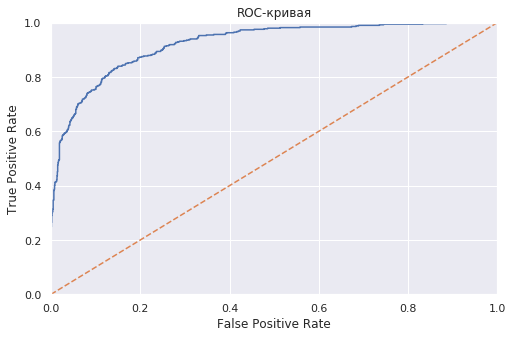

In [55]:
test_scoring(lgbm_fitted)

Модель показывает более чем приемлимый результат. Значение контрольной метрики ROC-AUC достигает **0,923**, что означает, что предложенная модель может использоваться в качестве решения для поставленной выше задачи, а именно предсказания пользователей потенциально нелояльных к оператору связи "Ниединогоразрыва.ком"

Оценим важность признаков, по которым училась модель

In [56]:
feature_importances = pd.DataFrame(data=lgbm_fitted.feature_importances_,
                                   index=X_train.columns, columns=['Importance of feature']).sort_values(
                                    by='Importance of feature',ascending=False)
feature_importances

,Importance of feature
MonthlyCharges,7911
DaysInUse,6660
TotalCharges,6048
gender_Male,1251
Partner_Yes,727
PaperlessBilling_Yes,716
PaymentMethod_Electronic check,664
Dependents_Yes,629
OnlineBackup_Yes,518
DeviceProtection_Yes,510


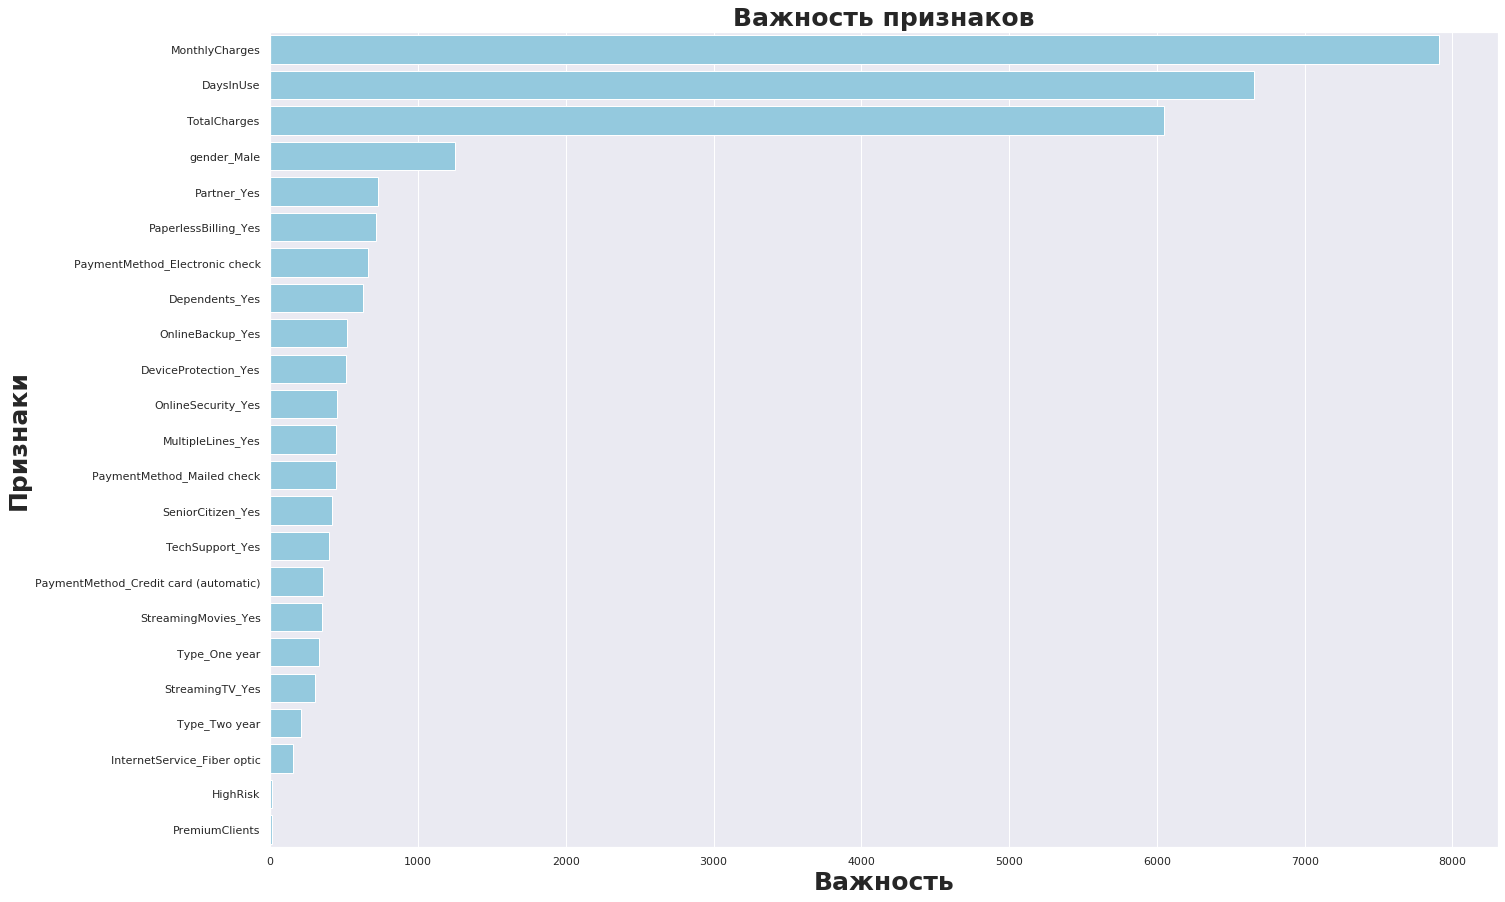

None

In [57]:
#sns.set(font_scale = 5)
#sns.set(color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(22,15)
sns.barplot(x=feature_importances['Importance of feature'],
            y=feature_importances.index, data=feature_importances,
            color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())

Как видно из полученного графика, наиболее важными признаками оказались ежемесячная плата, количество дней пользования услугами т общие затраты на связь. Наименее важными оказались смоделированные нами признаки, поэтому при возникновении необходимости доработки модели следует избавиться от них.

Удалим сгенерированные фичи и три наименее важные фичи из оригинального датасета

In [59]:
X_train_ups = X_train_ups.drop(['StreamingTV_Yes' ,'Type_Two year', 'InternetService_Fiber optic', 
                                'HighRisk', 'PremiumClients'], axis=1)

In [60]:
X_test = X_test.drop(['StreamingTV_Yes' ,'Type_Two year', 'InternetService_Fiber optic', 
                                'HighRisk', 'PremiumClients'], axis=1)

Проверим, как изменились метрики и время обучения модели

In [61]:
%%time
lgbm_fitted = model_learning(lgbm, lgbm_param)

Лучшая оценка на валидации:  0.983990395610551
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Лучшая модель:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', l2_leaf_reg=1, learning_rate=0.1,
               max_depth=9, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
CPU times: user 14min 12s, sys: 9.21 s, total: 14min 21s
Wall time: 14min 34s


Accuracy:  0.873
Presicion:  0.783
Recall:  0.737
AUC-ROC:  0.922


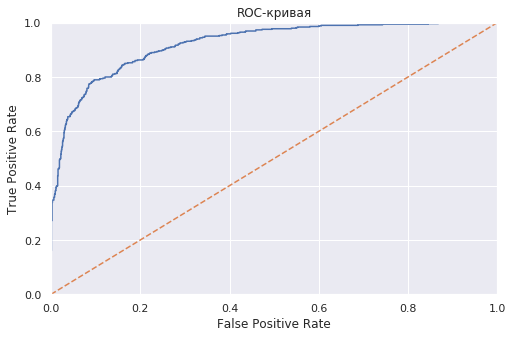

In [62]:
test_scoring(lgbm_fitted)

Метрика ROC-AUC уменьшилась на одну тысячную, что вполне может быть погрешностью, а время обучения сократилось на 3 минуты, что можно считать достойным результатом. Кроме того, признаки, мало влияющие на итоговый результат, могут приводить к переобучению, поэтому в данном случае принцип "чем больше, тем лечше" не совсем уместен.

## Вывод

По результатам проделанной работы наблюдаются следующие выводы:
 - найдены зависимости между лояльностью клиентов и их "сценариями" пользования услугами оператора
 - найдены зависимости между некоторыми персональными данными клиентов и их потенциальной лояльностью оператору
 - были сгенерированы допольнительные признаки, позволившие долбиться высокого качества модели
 - проверка важности признаков после первого обучения позволила сократить их список и ускорить обучение модели
 - была предложена модель бустинга, показавшая значение контрольной метрики ROC-AUC выше 0,9 при высоком времени обучения модели, что позволяет нам предложить полученную модель в качестве решения задачи по предсказнию оттока клиентов оператора "Ниединогоразрыва.ком"